Step 1
Load Wine dataset

In [1]:
from sklearn.datasets import load_wine
dataset = load_wine()
dataset.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2])

Step 2
Select the first two attributes for a 2D representation of the image

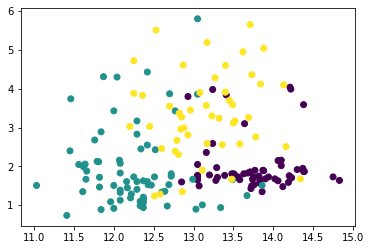

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

y_true = dataset.target
X = dataset.data[:,:2]

plt.scatter(X[:,0], X[:,1], c=y_true)
plt.show()


Step 3
Randomly split data into train, validation and test sets in proportion 5:2:3

In [3]:
from sklearn.model_selection import train_test_split

X_trainVal, X_test, y_trainVal, y_test = train_test_split(X, y_true, test_size=3/10, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=2/7, random_state=42)

print(f"Proportion train:validation:test -> {round(10*len(X_train)/len(X))}:{round(10*len(X_val)/len(X))}:{round(10*len(X_test)/len(X))}")

Proportion train:validation:test -> 5:2:3


Step 4
For K = [1,3,5,7]:
1. Apply K-Nearest Neighbors
2. Plot the data and the decision boundaries
3. Evaluate the method on the validation set

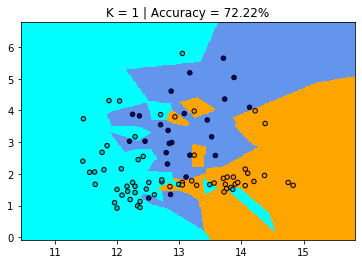

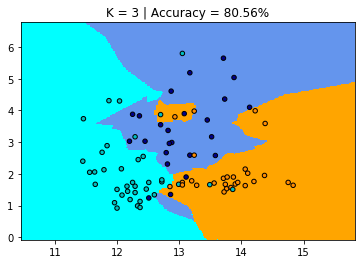

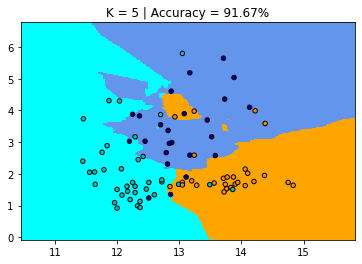

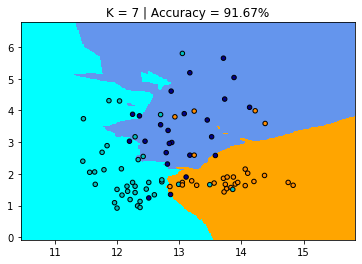

In [12]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

K = [1,3,5,7]
knns = [KNeighborsClassifier(n_neighbors=k) for k in K]

for knn in knns:
    knn.fit(X_train, y_train)

Ys_pred = [knn.predict(X_val) for knn in knns]
accuracies = [accuracy_score(y_val, y_pred) for y_pred in Ys_pred]

# Create color maps
cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

# Mesh grid parameter
step_size = .02
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

#Build meshgrid
xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size), np.arange(y_min, y_max, step_size))
for knn,k,acc in zip(knns,K,accuracies):
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    # Plot also the training points
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap=cmap_bold, s=20, edgecolors="k")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"K = {k} | Accuracy = {acc*100:.2f}%")
    
plt.show()

Plot a graph showing how the accuracy on the validation set 
varies when changing K
